In [ ]:
# importamos la libreria pytorch
import torch
from torch import nn
from torch import optim #las funciones de optimizacion (gradient descent)
from torch.optim.lr_scheduler import StepLR #learning rate decay
import torch.nn.functional as F #convencion
from torchvision import datasets, transforms

# matplotlib para pintar graficas
import matplotlib.pyplot as plt
%matplotlib inline

# torchview para pintar el diagrama con la arquitectura de red
%pip install git+https://github.com/mert-kurttutan/torchview.git
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

  Cloning https://github.com/mert-kurttutan/torchview.git to /tmp/pip-req-build-tydykl36
  Running command git clone --filter=blob:none --quiet https://github.com/mert-kurttutan/torchview.git /tmp/pip-req-build-tydykl36
  Resolved https://github.com/mert-kurttutan/torchview.git to commit c640a4a55e49183fe05a8673f0a6d43943fbe84b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchview: filename=torchview-0.2.6-py3-none-any.whl size=25416 sha256=60b4b2af6c7b370622bb42c45e0f341f06158b2b7a805decdccd26ef10e88d04
  Stored in directory: /tmp/pip-ephem-wheel-cache-eh3kz4d6/wheels/da/1e/01/dc3f612d3119cde4bff91b0aa192bdf07d67e6a7a981baa686
Successfully built torchview


'svg'

In [ ]:
# usamos la GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Dispositivo usado: GPU con CUDA")
else:
  device = torch.device("cpu")
  print("Dispositivo usado: CPU")

Dispositivo usado: GPU con CUDA


In [ ]:
# Definir una transformación para convertir la imagen a un tensor
transform=transforms.Compose([
    transforms.ToTensor(), # hay que convertir a tensor los datos
    transforms.Normalize((0.1307,), (0.3081,)) # normalizacion del dataset
    ])

# Descargar el dataset MNIST de numeros escritos a mano
dataset_train = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST('data', train=False, download=True, transform=transform)

# tamaño del mini-batch
batch_size = 64
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}

# generamos los dataloaders que se usaran para leer
# las imagenes el entrenamiento y test
train_loader = torch.utils.data.DataLoader(dataset_train, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

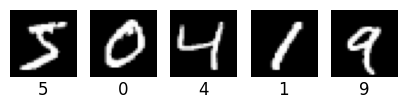

In [ ]:
# primero, vemos unas imagenes del set de entrenamiento con sus etiquetas (labels)
figure = plt.figure(figsize=(5, 1))

for i in range(0,5):
  figure.add_subplot(1, 5, i+1)
  img, label = dataset_train[i]

  # img tiene dimensiones [1,28,28], squeeze() destruye las dimensiones de tamaño 1
  plt.imshow(img.squeeze(), cmap='Greys_r')
  plt.axis('off')
  plt.title(label, y=-0.4)

# Definicion de la red neuronal

En este bloque se detallan las capas que conforman la red, aquí podemos tocar el número y tipo de las capas, sus hiperparámetros, y las funciones de activación usadas.

Hay que tener especial cuidado con las convoluciones para asegurarse de saber la forma que tiene el tensor en cada paso y configurar cada capa en consecuencia. Para ello es muy util imprimir por pantalla la forma de los tensores con `x.shape`. Se ha añadadido comentado el código para imprimir la forma del tensor.

El tamaño de la entrada en ese caso es un tensor con forma [batch_size, 1, 28, 28] debido al tamaño de las imágenes del dataset (28x28 pixeles)

Tampoco se debe cambiar el tamaño de la salida de ultima capa (output_size = 10) puesto que hace referencia al número de clases (10 clases, los números del 0 al 9)

In [ ]:
# Define la estructura básica de un bloque residual
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.5)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.5)

        # la conexion residual
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels, momentum=0.5)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define la estructura de la red ResNet
num_blocks = [2, 2, 2, 2]

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 8
        #convolucion inicial con batchnorm y relu
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, momentum=0.5)
        self.relu = nn.ReLU(inplace=True)

        # bloques residuales
        self.layer1 = self.make_layer(ResidualBlock, 8, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 16, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 32, num_blocks[2], stride=2)

        # pooling al final de la red
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10) # 10 = numero de clases
        # softmax para convertir la salida de la ultima capa en un
        # tensor de probabilidades que suma 1
        self.softmax = nn.Softmax(dim=1)

    # esta funcion crea los bloques residuales
    # cada bloque va teniendo menor tamaño (ancho/alto) y mas dimensiones
    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = self.softmax(out)
        return out

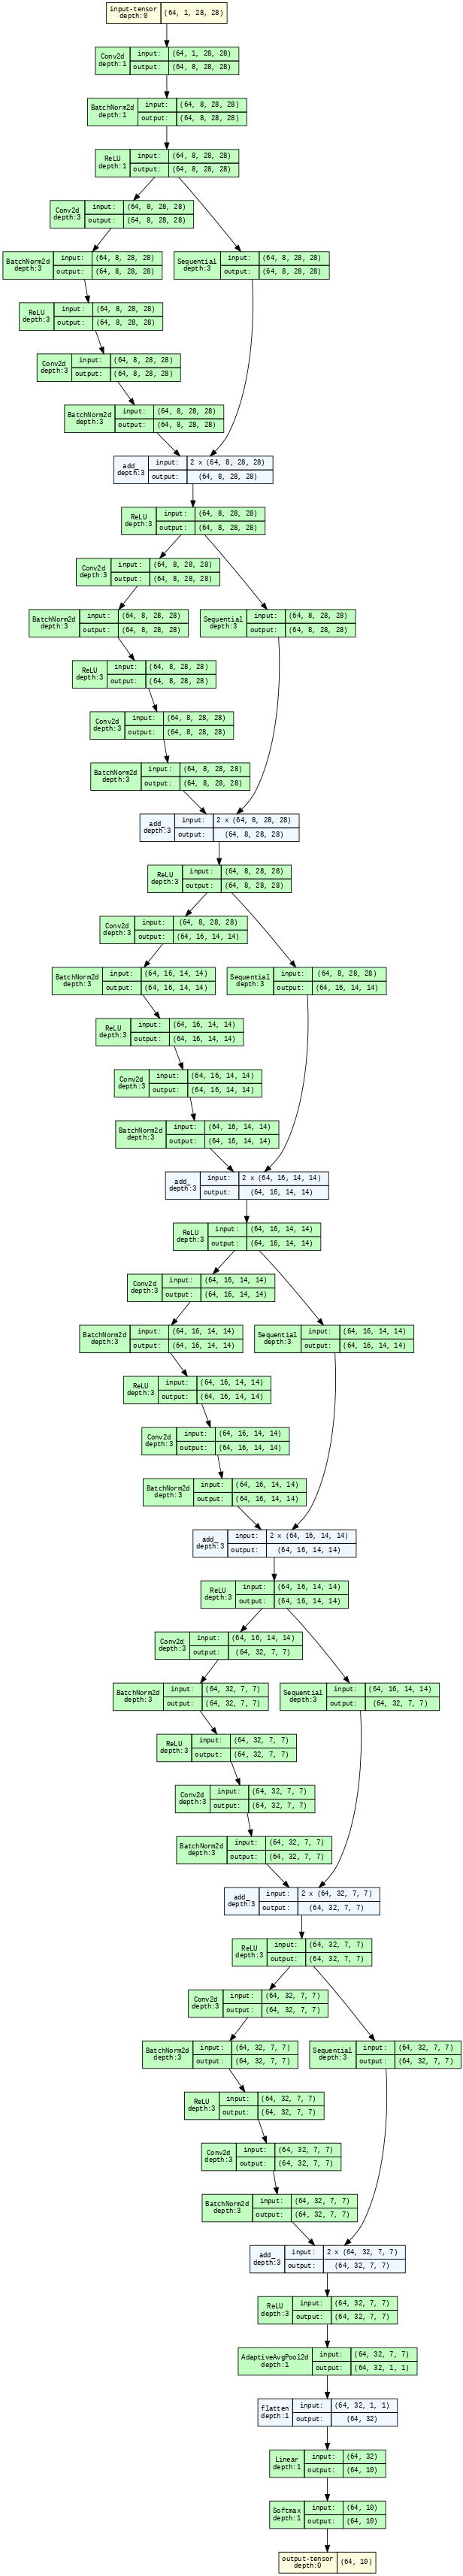

In [ ]:
# diagrama con la arquitectura de red
model = ResNet();
model_graph = draw_graph(model, input_size=(batch_size, 1,28,28))
model_graph.visual_graph

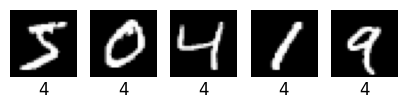

In [ ]:
# Como se comporta la red neuronal antes de entrenar?

# primero, inicializamos el generador de numeros aleatorios
# con una semilla, para obtener resultados deterministas
torch.manual_seed(42)

# Creamos una instancia del modelo
model = ResNet();

# generamos un grafico para representar las imagenes
figure = plt.figure(figsize=(5, 1))

for i in range(0,5):

  # calculamos la salida del modelo con los parametros iniciales aleatorios
  output = model(dataset_train.data[i].view(1,1,28,28).float()) # broadcast

  # de las diez neuronas de salida, la que tenga
  # mayor valor corresponde a la prediccion del modelo
  pred = output.argmax(dim=1, keepdim=True)

  # graficamos el resultado
  figure.add_subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(dataset_train.data[i], cmap='Greys_r')
  plt.title(pred.item(), y=-0.4)

# Regularizacion

Aqui se configura si se quiere o no usar regularizacion, de que tipo, y con que intensidad

In [ ]:
# Tipo de regularizacion
# ["Disabled", "L1 (Lasso)", "L2 (Ridge)", "Elastic Net"]
regularization = "L2 (Ridge)"

# Intensidad de la regularizacion L1
l1_weight = 0.00001

# Intensidad de la regularizacion L2
l2_weight = 0.0001

# Función de entrenamiento

La función de entrenamiento lanza los forward y backward passes, para actualizar los parametros de la red.

En este bloque lo único que se puede cambiar es la función de pérdida, para usar otra en lugar del error cuadrático medio.

In [ ]:
# funcion de entrenamiento
def train(model):

    # configurar el modelo en modo entrenamiento
    # se necesita para que capas como batchnorm o dropout se comporten correctamente
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # mandamos los datos al dispositivo (necesario cuando se usa la GPU)
        data, target = data.to(device), target.to(device)

        # calculamos la salida del modelo (prediccion)
        output = model(data) # en este caso data ya tiene la forma apropiada igual que la entrada del modelo

        # definimos la funcion de perdida como el error cuadratico medio
        # como la prediccion del modelo es un vector de 10 elementos (las 10 neuronales finales)
        # hay que convertir la label del set de entrenamiento en un vector
        # con el valor correspondiente 1 y todos los demas valores 0 (un vector one-hot)
        target_onehot = F.one_hot(target, num_classes=10).float()
        loss = F.mse_loss(output, target_onehot)

       # se suman los terminos de regularizacion si esta activada
        if regularization == "L1 (Lasso)" or regularization == "Elastic Net":
            l1_term = l1_weight * sum([p.abs().sum() for p in model.parameters()])
            # se escala para que las graficas del loss al final sean comparables
            l1_term /= 10
            loss += l1_term
        if regularization == "L2 (Ridge)" or regularization == "Elastic Net":
            l2_term = l2_weight * sum([(p**2).sum() for p in model.parameters()])
            # se escala para que las graficas del loss al final sean comparables
            l2_term /= 10
            loss += l2_term

        # se ejecuta el backpropagation para calcular el gradiente
        loss.backward()

        # se guarda el historico de la perdida para graficarlo
        loss_training.append(loss.item())

        # se actualizan los pesos y sesgos de la red
        optimizer.step()

        # se resetean a cero los gradientes
        optimizer.zero_grad()

        # cada 50 mini-batches, imprimimos por pantalla la perdida
        print_interval = 50
        if batch_idx % print_interval == 0:
            print('   Loss: ', loss.item())

    print('Training Epoch completa\n')

# Función de test

La función de test lanza el forward pass para calcular la perdida y precisión sobre el set de test o entrenamiento.

En este bloque lo único que se puede cambiar es la función de pérdida, para usar otra en lugar del error cuadrático medio. Debería usarse la misma que en la función de entrenamiento, para que los valores de la perdida sean comparables entre ambas funciones.

In [ ]:
# funcion de test
def test(model, split):

    # podemos ejecutar el test sobre el split de test o el training
    # asi vemos despues si tenemos overfitting
    if split == 'train':
        loader = train_loader
        loss_history = loss_train_split
    else:
        loader = test_loader
        loss_history = loss_test_split

    # configurar el modelo en modo evaluacion o inferencia
    # se necesita para que capas como batchnorm o dropout se comporten correctamente
    model.eval()

    # lista para almacenar los fallos,
    # global para que se pueda consultar fuera de la funcion
    global errorList
    errorList = []
    correct = 0
    test_loss = 0

    # durante el test solo hacemos el forward pass y no necesitamos los gradientes
    with torch.no_grad():
        for data, target in loader:

            # mandamos los datos al dispositivo (necesario cuando se usa la GPU)
            data, target = data.to(device), target.to(device)

            # calculamos la salida del modelo (prediccion)
            output = model(data)
            target_onehot = F.one_hot(target, num_classes=10).float()

            # suma acumulada de la pérdida
            test_loss += F.mse_loss(output, target_onehot, reduction='sum')

            # se suman los terminos de regularizacion si esta activada
            if regularization == "L1 (Lasso)" or regularization == "Elastic Net":
                l1_term = l1_weight * sum([p.abs().sum() for p in model.parameters()])
                # se escala para que las graficas del loss al final sean comparables
                l1_term *= data.size(0)
                test_loss += l1_term
            if regularization == "L2 (Ridge)" or regularization == "Elastic Net":
                l2_term = l2_weight * sum([(p**2).sum() for p in model.parameters()])
                # se escala para que las graficas del loss al final sean comparables
                l2_term *= data.size(0)
                test_loss += l2_term

            # de las diez neuronas de salida, la que tenga
            # mayor valor corresponde a la prediccion del modelo
            pred = output.argmax(dim=1, keepdim=True)

            # si la prediccion es igual al valor etiquetado, se cuenta como correcto
            correct += pred.eq(target.view_as(pred)).sum().item()

            # los que no sean iguales al valor etiquetado,
            # se meten en un array de errores
            for index, error in enumerate(pred.ne(target.view_as(pred))):
              if (error):
                errorList.append({
                    "data": data[index],
                    "pred": pred[index],
                    "target": target[index]
                    })

    # se divide el acumulado de la perdida por el tamaño del dataset
    # para obtener la media de la perdida
    # se divide tambien por 10, que es el tamaño del one-hot vector (el numero de clases)
    test_loss /= len(loader.dataset)*10

    # se guarda el historico de la perdida en el test para graficarlo
    loss_history.append(test_loss.item())

    # imprimir por pantalla los resultados del test
    print('Test (split ', split,
          '):\n   Loss medio: ', test_loss.item(),
          'Errores: ',  len(errorList),
          'Precision: ', 100 * correct / len(loader.dataset), '%\n')


In [ ]:
# ejecutamos un test antes de empezar el entrenamiento
# la precision debe ser sobre el 10% (como hay 10 etiquetas,
# 1 de cada 10 el modelo acertara)
model = ResNet()
model.to(device)
loss_test_split = []
test(model, 'test')

Test (split  test ):
   Loss medio:  0.09380871802568436 Errores:  8991 Precision:  10.09 %


# Bucle de entrenamiento

En este bloque se inicializa la red y se ejecuta el entrenamiento y test tantas veces como Epochs se hayan configurado.

De este bloque puede editarse la función de optimización, para usar otra en lugar del SGD, el scheduler, que rige como evoluciona el learning rate (pueden cambiarse los parámetors del scheduler, usar otro scheduler, editar el learning rate a mano, o dejarlo fijo) o el número de epochs.

In [ ]:
# entrenamos la red

# semilla del generador de numeros aleatorios
# para conseguir resultados deterministas
torch.manual_seed(42)

# lista para graficar la perdida de entrenamiento y test
loss_training = []
loss_test_split = []
loss_train_split = []

# Crear una instancia del modelo y pasarla al dispositivo
model = ResNet()
model.to(device)

# optimizador, mini-batch gradient descent
# (en pytorch le llaman stochastic gradient descent, pero es un mini-batch gradient descent)
# para regularizacion L2, se puede añadir el argumento weight_decay del optimizador
optimizer = optim.SGD(model.parameters(), lr=1.0)

# learning rate decay, se multiplica por gamma cada step_size steps
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

epochs = 10
for epoch in range(0, epochs):
    print('Epoch:', epoch, 'LR:', scheduler.get_last_lr())
    train(model)
    test(model, 'test')
    test(model, 'train')
    scheduler.step()


Epoch: 0 LR: [1.0]
   Loss:  0.10242480039596558
   Loss:  0.07993002980947495
   Loss:  0.05716349557042122
   Loss:  0.042356330901384354
   Loss:  0.022939514368772507
   Loss:  0.02372857928276062
   Loss:  0.021221809089183807
   Loss:  0.01034587062895298
   Loss:  0.01219065859913826
   Loss:  0.007606270723044872
   Loss:  0.008102638646960258
   Loss:  0.012772167101502419
   Loss:  0.010307367891073227
   Loss:  0.010429851710796356
   Loss:  0.013304312713444233
   Loss:  0.008420351892709732
   Loss:  0.011905185878276825
   Loss:  0.006923663429915905
   Loss:  0.00922640971839428
Training Epoch completa

Test (split  test ):
   Loss medio:  0.008502937853336334 Errores:  282 Precision:  97.18 %

Test (split  train ):
   Loss medio:  0.008604871109127998 Errores:  1654 Precision:  97.24333333333334 %

Epoch: 1 LR: [0.7]
   Loss:  0.00881445873528719
   Loss:  0.004698046483099461
   Loss:  0.007802668958902359
   Loss:  0.005948828067630529
   Loss:  0.006875455379486084
 

# Analisis de datos post-entrenamiento

Aqui podemos ver como ha evolucionado la perdida durante el entrenamiento (para ver si ha convergido bien), la diferencia entre la perdida del set de entrenamiento y test (para ver si hay overfitting) y el resultado de la red para varias imagenes de entrada.

Por ultimo, se muestran varios casos en los que la red clasifica erroneamente la imagen.

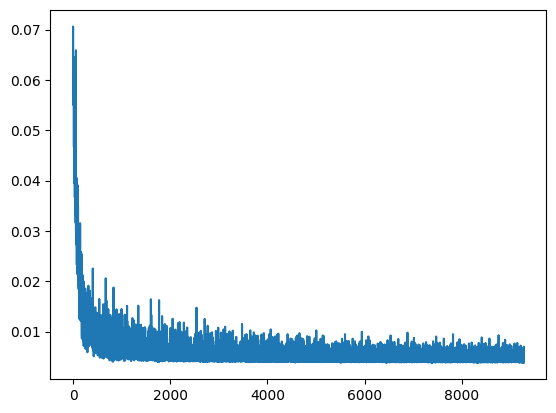

In [ ]:
# graficamos la perdida durante el entrenamiento
plt.plot(loss_training[100:])

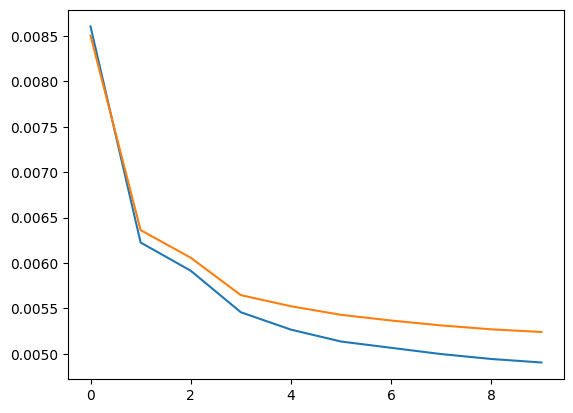

In [ ]:
# graficamos la perdida del split entero de train vs. test
# para ver como de bien generaliza el modelo
plt.plot(loss_train_split)
plt.plot(loss_test_split)

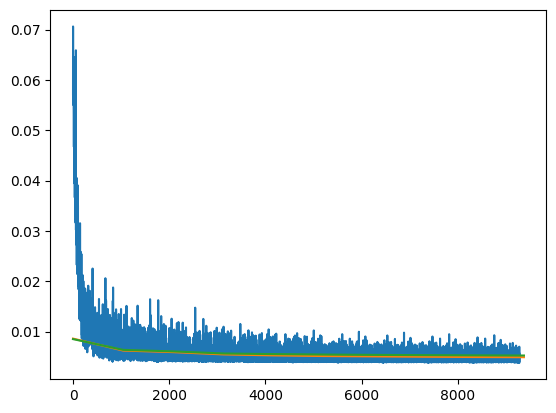

In [ ]:
# comparar la perdida durante el entrenamiento y la de los splits enteros
plt.plot(loss_training[100:])
x = torch.linspace(0, epochs*len(train_loader.dataset)/batch_size, epochs)
plt.plot(x,loss_train_split)
plt.plot(x,loss_test_split)

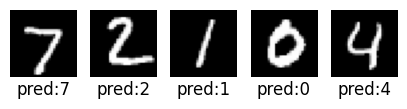

In [ ]:
# pintamos algunas predicciones
figure = plt.figure(figsize=(5, 1))

# cargamos las imagenes del loader
data, target = next(iter(test_loader))
model.eval()
model.zero_grad()

with torch.no_grad():
  for i in range(0,5):

    # calcula la salida del modelo con los parametros entrenados
    input = data[i].view(1,1,28,28).float().to(device)
    output = model(input)

    # de las diez neuronas de salida, la que tenga
    # mayor valor corresponde a la prediccion del modelo
    pred = output.argmax(dim=1, keepdim=True)

    # pintamos la imagen y la prediccion del modelo
    figure.add_subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(data[i].view(28,28), cmap='Greys_r')
    plt.title("pred:" + str(pred.item()), y=-0.4)

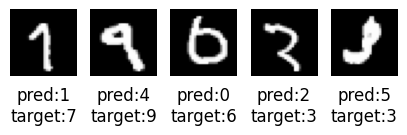

In [ ]:
# pintamos algunas de las predicciones incorrectas
figure = plt.figure(figsize=(5, 1))

for i in range(0,5):
  figure.add_subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(errorList[i]["data"].view(28,28).cpu(), cmap='Greys_r')
  plt.title(
      "pred:" + str(errorList[i]["pred"].item()) +
      "\ntarget:" + str(errorList[i]["target"].item()),
      y=-0.8)